## Optimal Clustering

군집화 문제는 객체 집합과 이들 객체 집합과 연관이 있는 특성들의 집합으로 구성된다. 목적은 특성을 사용해서 객체들을 그룹으로 분리하는 것이다.
여기서 그룹 내 유사도가 최대화되고, 그들 간 유사도는 최소화된다. 과제를 푸는 데 있어서 알고리즘을 도울 예제를 제공하지 않기 때문에, 많은 금융 문제들에 있어서 대다수는 비지도학습의 행태를 띄고 있다.
군집화 문제는 투자 프로세스의 모든 단계에서 금융에 자연스럽게 나타난다. 예를 들어, 분석가들은 현재 사건과 유사한 과거 사건을 찾을 것이며, 이는 사건의 수치적 분류 체계를 개발하는 것과 관련된다.
포트폴리오 매니저들은 종종 다양한 특성에 대해 증권을 군집화해 동료 기업 간의 상대 가치를 도출한다. 리스크 매니저들은 공통 특성을 공유하는 증권에 집중하는 것을 피하고자 한다.(분산투자) 
증권 집합에 영향을 주는 흐름을 이해하고, 상승세 또는 대규모 매도가 특정 증권에 특수한 것인지 또는 여러 증권에 의해 공유된 범주에 영향을 미치는 것인지를 결정하기 원할 것이다.
이들 문제를 해결하는 데 있어 상관관계 기반의 거리를 비롯한 다양한 거리 개념을 사용한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

TICKERS = pd.read_excel('S&P500_ticker_list.xlsx')['Symbol'].tolist()
START_DATE = '2010-01-01'
END_DATE = pd.to_datetime('today')

data = yf.download(
    TICKERS,
    start = START_DATE,
    end = END_DATE,
    progress = True
)['Close']

[*********************100%%**********************]  503 of 503 completed


In [2]:
data = data.resample('W').last().dropna(axis = 1)
ret = data.pct_change().dropna()

### 근접성 행렬

$N \times F$ 차수의 데이터 행렬 $X$를 고려하자. 
여기서 $N$은 샘플의 수이고, $F$는 특성의 수이다. $F$특성을 사용해 $N$개의 샘플 간의 $N \times N$행렬로 표현되는 근접성을 계산한다. 근접성 척도는 유사도 또는 비유사도를 가리킬 수 있다. 비유사도 척도가 거리 척도의 조건을 만족하는 것은 편리하나 반드시 필요하지는 않다. 근접성 행렬은 무방향성 그래프로 표현될 수 있다. 그래프 엣지의 가중치는 유사도 또는 비유사도의 함수이다. 그러면 군집화 문제는 그래프를 연결된 구성 요소로 분할하는 것과 동일하다. 근접성 형성할 때 입력을 표준화해 한 특성의 크기가 나머지를 지배하는 것을 방지하는 것은 좋은 아이디어이다.

### 군집화 종류

두 종류의 주요 군집화 알고리즘, 즉 분할과 계층적 군집화 알고리즘이 있다. 분할 기법은 객체를 한 수준에서 분할한다. 계층적 기법은 하나의 모든 샘플을 포함하는 군집을 최정상으로 하고, 개별 포인트의 단일점으로 이뤄진 군집을 바닥으로 하는 분할의 중첩된 시퀀스를 생성한다. 계층적 군집화 알고리즘은 분할적일 수도 있고, 응집형일 수도 있다. 계층적 트리의 성장을 제약함으로써 계층적 군집화로부터 분할 군집화를 도출할 수 있다. 그러나 일반적으로 분할 군집화로부터 계층적 군집화를 도출할 수는 없다.

군집화의 정의에 따라 여러 유형의 군집화 알고리즘을 구별할 수 있다. 이는 다음을 포함한다.

1. 연결성 : 이 군집화는 계층적 군집화와 같이 거리 연결성을 기반으로 한다. 금융에서의 예를 위해 Lopez de Prado(2016)을 참고하자.
2. 중심 : 이들 알고리즘은 k-means와 같이 벡터 양자화를 수행한다. 금융에서의 예를 위해서는 Lopez de Prado와 Lewis(2018)을 참고하자.
3. 분포 : 군집이 통계 분포를 이용해 형성된다
4. 밀도 : 이들 알고리즘은 데이터 공간의 연결되고 밀집된 공간을 탐색한다. 예는 DBSCAN과 OPTICS를 들 수 있다.
5. 하위 공간 : 군집들이 특성과 관측의 2차원 위에 모델링된다. 예는 양방향 군집화이다. 예를 들어, 증권과 기간의 부분 집합들 간의 유사도를 동시에 식별할 수 있다.

어떤 알고리즘은 유사도 척도를 입력으로 요구하고, 다른 알고리즘은 비유사도 척도를 입력으로 기대한다. 특정 알고리즘에 올바른 입력을 전달하는 것은 중요하다. 예를 들어, 계층적 알고리즘은 전형적으로 거리를 입력으로 취하고, 이는 이웃에 있는 아이템을 군집화할 것이다. 중심, 분포, 밀도 방법은 벡터 공간 좌표를 기대하며, 거리를 직접 다룬다. 그러나 거리 행렬을 바로 이용하는 양방향 군집화는 가장 거리가 먼 원소들을 군집화한다. 이를 수행하는 하나의 방법은 거리의 역수에 대해서 양방향 군집화하는 것이다.

만약 특성수가 관측수를 많이 초과한다면 차원의 저주는 군집화에 문제를 일으킨다. 관측을 생성하는 대부분의 공간이 빈 공간이어서 이떤 그룹을 식별하는 것도 어렵게 할 것이다. 이를 해결하는 하나의 방법은 PCA가 특성 수를 축소하는 것처럼 데이터 행렬 $X$를 저차원 공간에 투영하는 것이다. 또 하나의 해법은 근접성 행렬을 저차원 공간에 투영하고, 이를 새로운 $X$ 행렬로 사용하는 것이다. 두 경우 모두에 있어서, 잡음과 주음 제거는 신호에 연관된 차원 수를 식별하는 것을 돕는다.

### 군집의 수

분할 알고리즘은 비중첩 군집의 구성을 발견한다. 여기서 연구자는 정확한 군집 수를 제공해야 한다. 실무적으로 연구자는 군집 수가 얼마인지 미리 알 수 없다. Elbow Method는 설명되는 분산의 한계 비율이 미리 정의한 임계값을 초과하지 않을 때 군집을 더 이상 추가하지 않는 인기있는 기법이다. 이 맥락에서 설명되는 분산의 비율이 총 분산 대비 그룹 간 분산의 비율이 총 분산 대비 그룹 간 분산의 비율로 정의된다. 이 접근법의 한 가지 결함은 임계값이 종종 임의로 설정된다는 것이다.

#### 1. 관측 행렬

만약 문제가 상관계수 행렬과 관련되지 않거나 또는 이미 관측 행렬을 보유하고 있다면 이 절을 생략해도 좋다. 아니면 상관계수 행렬에 의해 특징지워지는 다변수 정규 분포를 따르는 N개의 변수를 갖고 있다고 가정하자. 여기서 $\rho_{i,j}$는 변수 $i$와 $j$간의 상관계수다. 만약 강한 공통 원소가 존재하면 2장에서 설명한 주음 제거 방법을 적용함으로써 이를 제거하는 것을 권장한다. 왜냐하면 모든 변수에 의해 공유하는 요인 노출은 부분적으로 공유하는 노출의 존재를 감출 수 있기 때문이다.

상관관계 군집화의 목적을 위해서 적어도 다음 3개의 접근법을 따른다.

1. 거리 행렬을 $d_{i,j} = \sqrt{\frac{1}{2}\left(1 - \rho_{i,j}\right)}$ 또는 유사한 변환으로 직접 정의함으로써 $X$행렬을 우회할 수 있다.
2. 상관관계 행렬을 $X$로 사용한다.
3. $X$ 행렬을 $X_{i,j} = \sqrt{\frac{1}{2}\left(1 - \rho_{i,j}\right)}$ 또는 유사한 변환으로 도출한다.

대안 2번과 3번의 이점은 두 변수 간의 거리는 단 하나가 아닌 다중 상관관계 추정치의 함수가 될 것이다. 이는 분석을 특이치의 존재에 더욱 강건하게 만든다. 대안 3번의 이점은 $\rho_{i,j} = 0.9$에서 $\rho_{i,j} = 1.0$으로의 변화가 $\rho_{i,j} = 0.1$에서 $\rho_{i,j} = 0.2$로의 변화보다 더 크다는 것을 인정하는 것이다. 이번 절에서는 3번의 접근법을 따르며, 관측 행렬을 $X_{i,j} = \sqrt{\frac{1}{2}\left(1 - \rho_{i,j}\right)}$로 정의한다.

상관관계 행렬의 군집화는 특성이 관측과 일치한다는 점에서 특별하다. 관측 그 자체가 특성인 관측들을 그룹화하고자 한다. 행렬 $X$는 거리 행렬같이 보이지만, 그렇지 않다. 그러나 여전히 거리가 평가될 수 있는 관측 행렬이다.

#### 2. 기본 군집화

이번 단계에서 척도 공간에서의 관측을 표현하는 행렬을 갖고 있다고 가정한다. 이 행렬은 이전에 기술된 바와 같은 방식 또는 다른 방법을 적용해 계산됐다고 가정한다. 예를 들어, 이 행렬은 이전 장에서 설명한 랜덤 변수 간의 정보 변분을 기반으로 할 수 있다. 다음 기본 군집화 알고리즘을 논의하자. 한 가지 가능성은 관측 행렬에 대해 k-means 알고리즘을 사용하는 것이다. k-means가 단순하고 많은 경우 유요한 반면, 2개의 눈에 띄는 제약을 가진다. 첫째, 알고리즘은 사용자 설정의 군집 수 K를 요구하는데 이것이 선험적으로 반드시 최적이라는 보장은 없다. 둘째, 초기화가 랜덤이어서 알고리즘의 결과가 유사하게 랜덤일 수 있다.

이러한 두 우려를 해결하고자 k-means 알고리즘을 수정해야 한다. 첫째, 수정은 최적의 $K$를 발견할 수 있도록 목적 함수를 도입하는 것이다. 이를 위해 Rousseeuw(1987)에 의해 도입된 실루엣 점수를 취한다. 주어진 원소 $i$와 주어진 군집화에 대해 실루엣 계수 $S_i$는 다음과 같이 정의되는 것을 상기하자.

$$S_i = \frac{b_i - a_i}{\max\{a_i, b_i\}} ; i = 1, \dots, N$$

여기서 $a_i$는 동일한 군집 내의 $i$와 다른 모든 원소와의 평균 거리이고, $b_i$는 $i$와 $i$가 그 구성원이 아닌 최근접 군집 내의 모든 원소와의 평균 거리다. 실제로 이는 군집 내 거리와 군집 간 거리를 비교하는 척도다. 값 $S_i = 1$은 원소 $i$가 잘 군집화됐다는 의미이며, $S_i = -1$은 $i$가 잘 군집화되지 못했다는 것을 의미한다. 주어진 분할에 대해 군집화 품질의 척도 $q$는 다음과 같이 정의된다.

$$q = \frac{E[\{S_i\}]}{\sqrt{V[\{S_i\}]}}$$

여기서 $E[\{S_i\}]$는 실루엣 계수의 평균이고, $V[\{S_i\}]$는 실루엣 계수의 분산이다. 두 번째 수정은 k-means의 초기화 문제를 다룬다. 기본 수준에서 군집화 알고리즘은 다음 연산을 수행한다.

1. 관측 행렬을 평가한다
2. 이중 for loop을 수행한다. 첫 번째 루프에서 하나의 주어진 초기화에 대해 k-means을 통해 군집화할 상이한 $k = 2, \dots, N$을 시도하고, 각 군집화에 대해 품질 $q$를 평가한다. 두 번째 루프는 첫 번째 루프를 여러 번 반복하고, 그에 따라 상이한 초기화를 시도한다.
3. 이들 두 루프에 대해 가장 높은 $q$를 가진 군집화를 선택한다

아래의 코드는 이 절차를 구현한다.

In [3]:
from FinancialMachineLearning.machine_learning.clustering import clusterKMeansBase, clusterKMeansTop
from FinancialMachineLearning.generator.pca_blocks import *

randomBlockCorr = get_random_block_correlation(
    nCols = 50, nBlocks = 10, random_state = 42, minBlockSize = 1
)

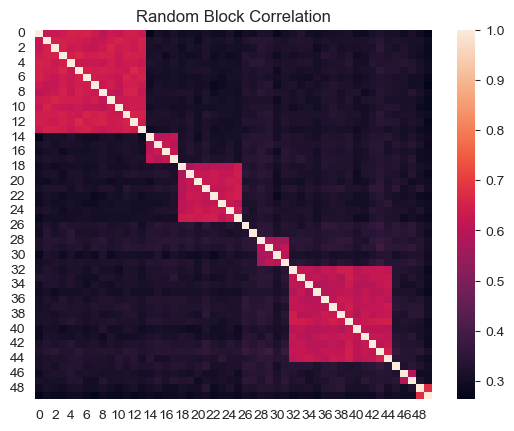

In [4]:
import seaborn as sns

sns.heatmap(
    randomBlockCorr
)
plt.title('Random Block Correlation')
plt.show()

In [5]:
corr1, clusters, silh_coef = clusterKMeansBase(
    randomBlockCorr, maxNumClusters = 10, n_init = 1
)

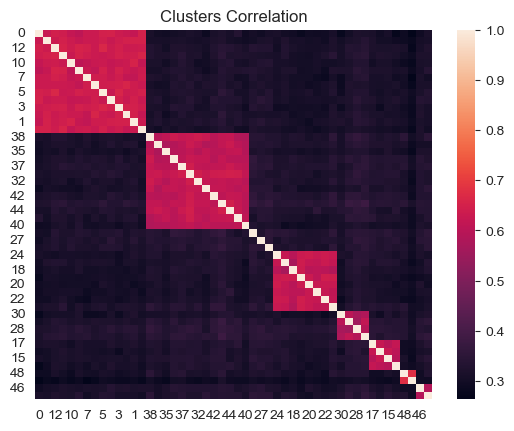

In [6]:
sns.heatmap(
    corr1
)
plt.title('Clusters Correlation')
plt.show()

#### 상위 수준 군집화

k-means에 대한 세 번째 수정은 품질의 일관성이 없는 군집을 다룬다. 기본 군집화는 거리가 더 먼 군집들을 포착하지만, 덜 뚜렷한 것들을 높친다. 이 문제를 다루고자 기본 군집화 알고리즘으로부터 군집화 품질 점수가 주어졌을 때 각 군집 $k = 1, \dots, K$의 품질 $q_k$를 평가한다. 그 다음 평균 품질 $\bar{q}$를 취해 평균보다 낮은 품질의 군집 집합 $\{q_k \vert q_k < \bar{q}, k = 1, \dots, K\}$을 발견한다. $K_1, K_1 < K$을 그 집합의 군집 수라고 표기하자. 만약 반환할 군집 수가 $K_1 \leq 1$이라면 기본 알고리즘에 의해 주어진 알고리즘을 반환한다. 그러나 만약 $K_1 \geq 2$라면 $K_1$개의 군집 내의 원소들에 대해 군집화를 다시 실행한다. 반면 나머지 원소들은 수용될 수 있도록 군집화가 된 것으로 간주한다.

$K_1$ 군집을 구성하는 원소들로부터 새로운 관측 행렬을 형성하고, 이 축소된 상관관계 행렬에 대한 기본 군집화 알고리즘을 다시 실행한다. 이렇게 하면 이들 $K_1$ 군집의 원소들에 대해 새로운 군집화를 반환 할 것이다. 그 효율성을 검사하고자, $K_1$의 원소들을 재군집화하기 전과 후의 평균 군집 품질을 비교한다. 만약 평균 군집 품질이 개선되면 새로 실행한 노드에 대한 새로운 군집화와 기본 군집화로부터 수용된 군집화를 병합해 돌려준다. 아래의 코드는 이 연산을 구현한다.

In [7]:
corr2, clusters2, silh_coef2 = clusterKMeansTop(
    randomBlockCorr, maxNumClusters = 10, n_init = 1
)

clstrs length:8
best clustr:8
clstrs length:3
best clustr:3
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[2] clstrs len:3
clstrs2.len, stat:3
newTstatMean > tStatMean41.73160593319761 (len:newClst)7 > 33.45036752683619 (len:Clst)8


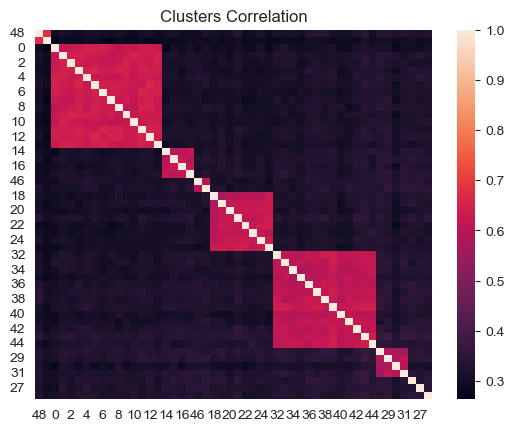

In [8]:
sns.heatmap(corr2)
plt.title('Clusters Correlation')
plt.show()

In [9]:
clusters2

{0: [48, 49],
 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 2: [14, 15, 16, 17],
 3: [46, 47],
 4: [18, 19, 20, 21, 22, 23, 24, 25],
 5: [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44],
 6: [28, 29, 30, 31, 26, 27, 45]}

In [10]:
silh_coef2

0     0.401304
1     0.399673
2     0.400885
3     0.413151
4     0.392005
5     0.409022
6     0.404685
7     0.395422
8     0.389888
9     0.401677
10    0.387454
11    0.408337
12    0.408037
13    0.405292
14    0.274405
15    0.269899
16    0.288989
17    0.277038
18    0.301853
19    0.322637
20    0.338984
21    0.320653
22    0.340242
23    0.327142
24    0.335116
25    0.346422
26   -0.013732
27   -0.014700
28    0.125298
29    0.126245
30    0.124889
31    0.124038
32    0.352160
33    0.346220
34    0.332866
35    0.336846
36    0.338018
37    0.348532
38    0.345375
39    0.374744
40    0.334374
41    0.347073
42    0.340613
43    0.344021
44    0.356279
45   -0.008523
46    0.237647
47    0.232445
48    0.332550
49    0.346123
dtype: float64

In [11]:
corr1, clusters, silh_coef = clusterKMeansBase(
    ret.corr(), maxNumClusters = 10, n_init = 10
)

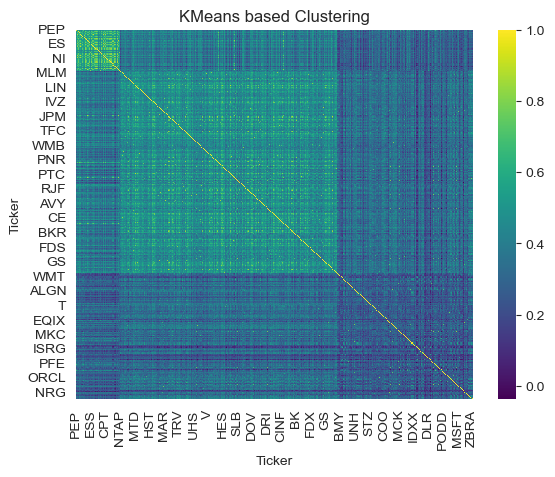

In [12]:
sns.heatmap(
    corr1,
    cmap = 'viridis'
)
plt.title('KMeans based Clustering')
plt.show()

In [13]:
corr2, clusters2, silh_coef2 = clusterKMeansTop(
    ret.corr(), maxNumClusters = 10, n_init = 10
)

clstrs length:3
best clustr:3
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[2] clstrs len:3


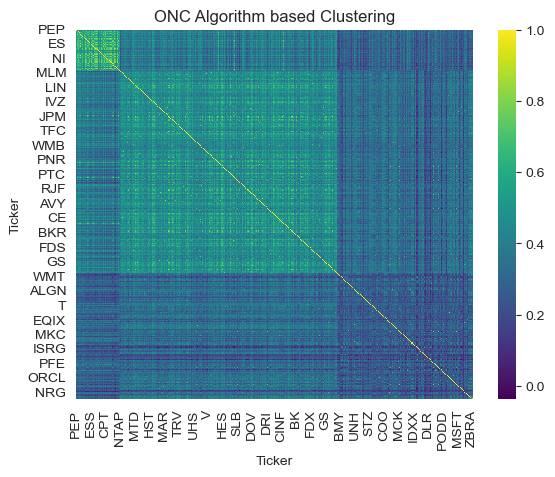

In [14]:
sns.heatmap(
    corr2,
    cmap = 'viridis'
)
plt.title('ONC Algorithm based Clustering')
plt.show()